# Tarea N°02

## Instrucciones

1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.


* __Nombre__: José Cea

* __Rol__: 201810524-4

2.- Debes _pushear_ este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:
    - Soluciones
    - Código
    - Que Binder esté bien configurado.
    - Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [3]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [4]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [5]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

In [6]:
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import warnings
import timeit
import time

warnings.filterwarnings("ignore")

sns.set_palette("deep", desat=.6)
sns.set(rc={'figure.figsize':(20,30)})
%matplotlib inline

In [7]:
digits.describe()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


¿Cómo se distribuyen los datos?

65


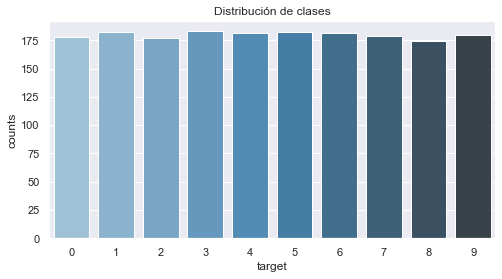

In [8]:
print(len(digits.columns))
gr = digits.groupby(['target']).size().reset_index(name='counts')
fig, ax = plt.subplots(figsize=(8,4),nrows=1)
sns.barplot(data=gr, x='target', y='counts', palette="Blues_d",ax=ax)
ax.set_title('Distribución de clases')
plt.show()
print("")

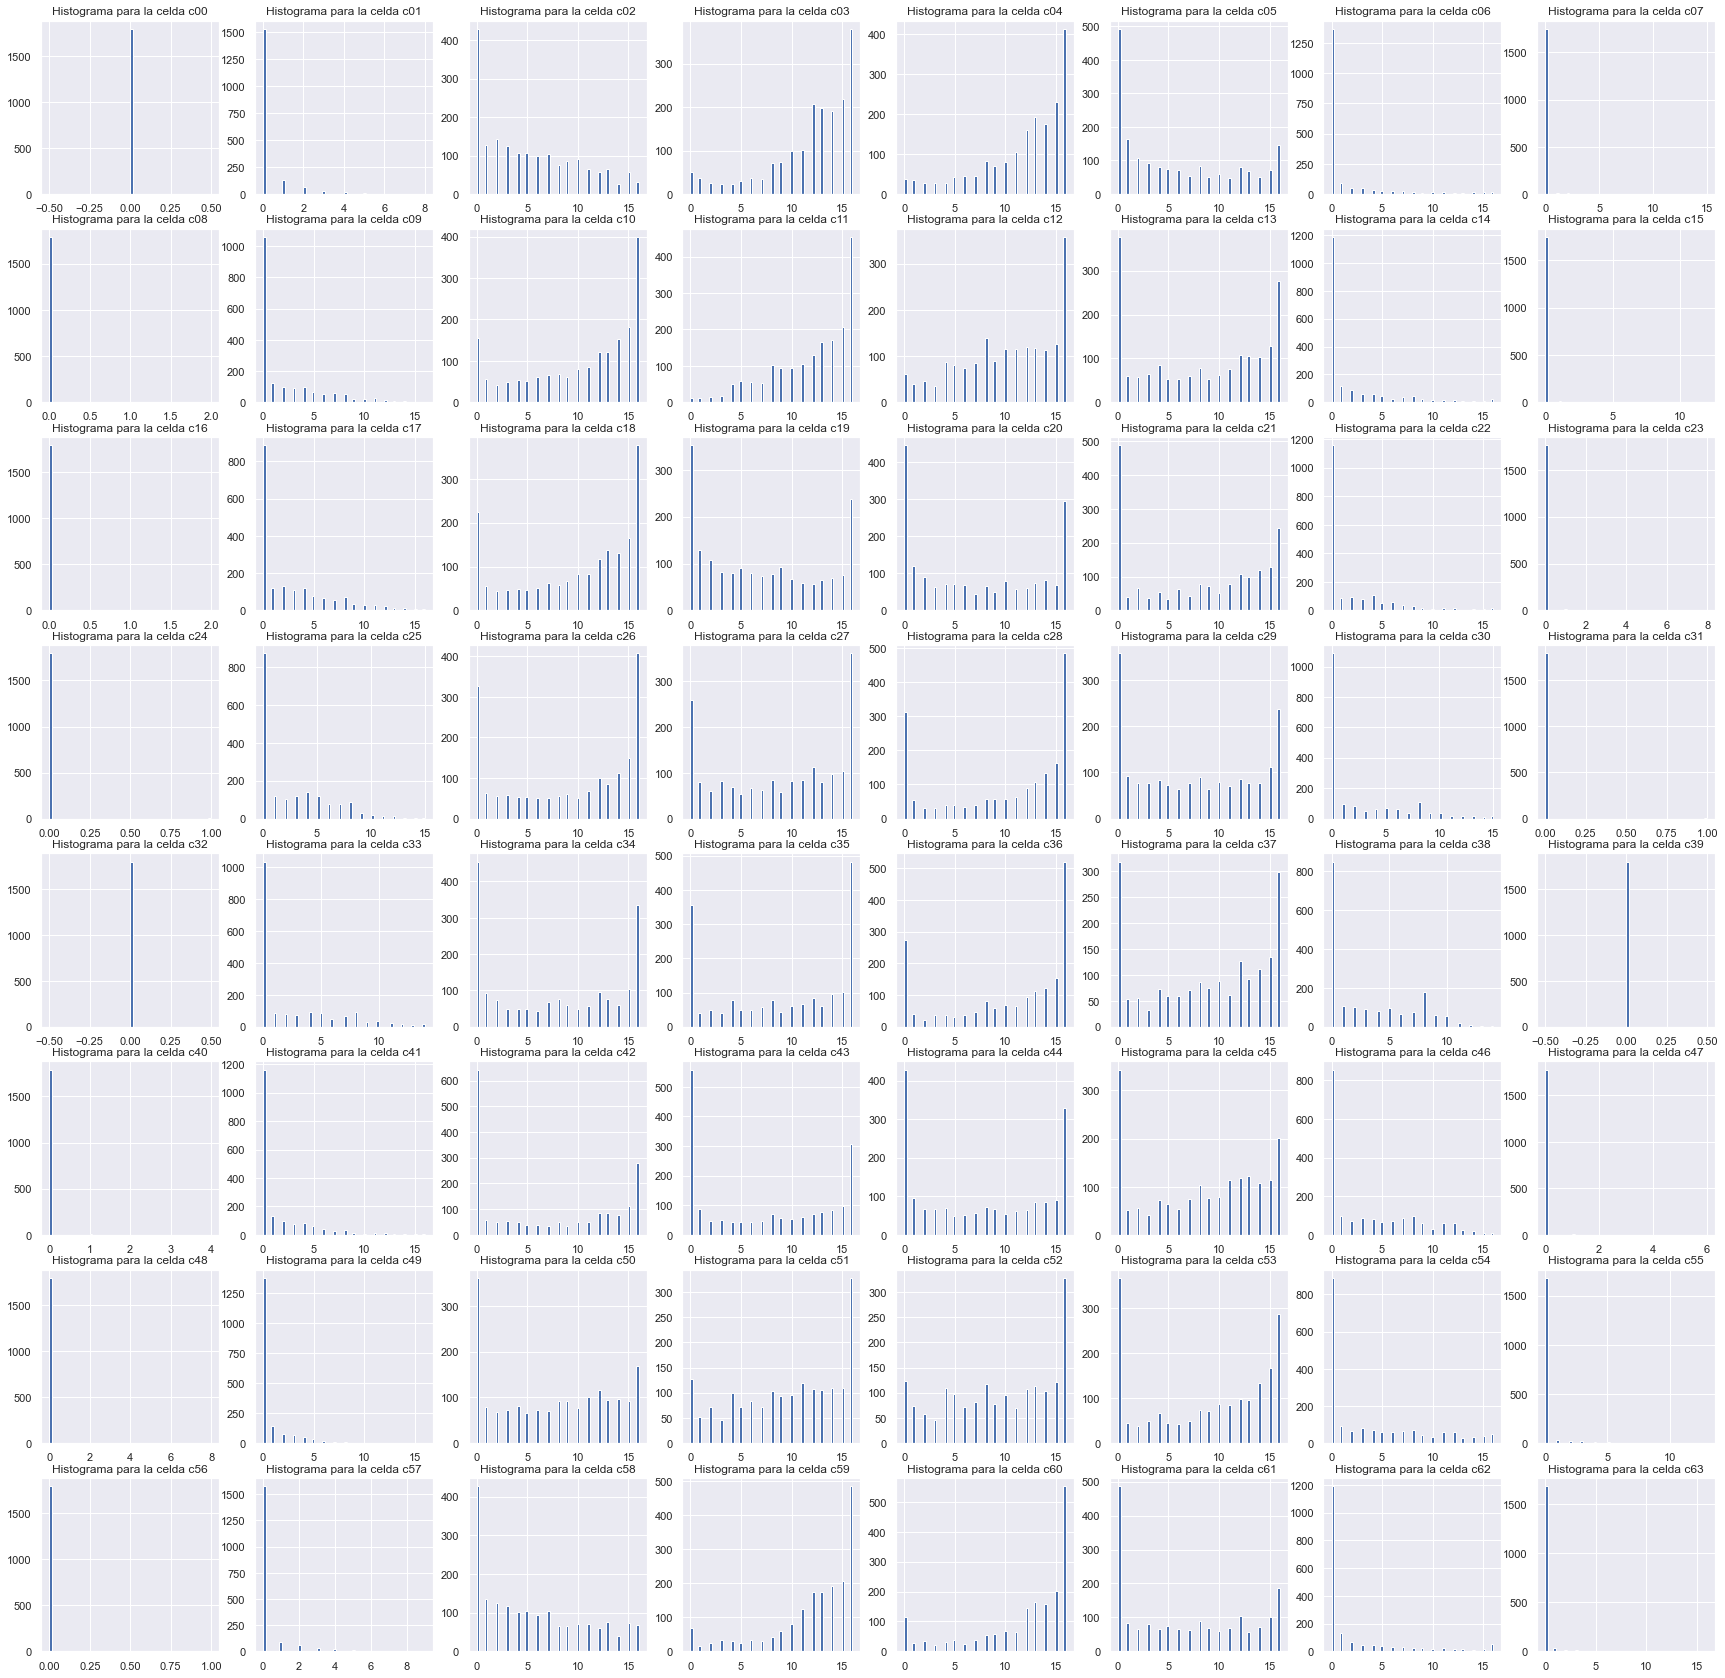

In [9]:
df=digits.drop(['target'],axis=1) #df sin target
figure(num=None, figsize=(30, 30)) #Ajustamos nuestra ventana de ploteo
k=1 #Establesemos un contador para el ploteo.
for i in df.columns: #recorrer columnas para generar histogramas
    plt.subplot(8,8,k)
    plt.hist(df[i], bins = 60)
    plt.title('Histograma para la celda '+i)
    k+=1

plt.show()

¿Cuánta memoria estoy utilizando?

In [10]:

import sys
memoria = digits.memory_usage() #Se determina la memoria usada en el DataFrame por columna
memoria
#Se suma la memoria de cada columna para conocer el total
total = 0
for i in range(0,len(memoria)):
    total += memoria[i] 
print(total,'bytes')

467348 bytes


¿Qué tipo de datos son?

In [11]:
#Tipos de datos
digits.dtypes.unique()

array([dtype('int32')], dtype=object)

¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

In [12]:
#Todos tienen la misma cantidad de elementos
digits.describe().T['count'].unique()

array([1797.])

### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [13]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

Sugerencia: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

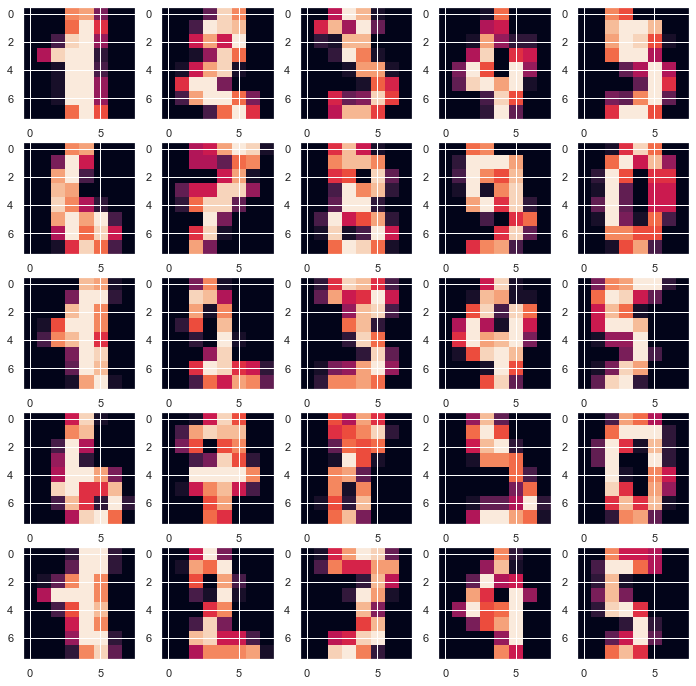

In [14]:
nx, ny = 5, 5
fig, axs = plt.subplots(nx, ny, figsize=(12, 12))
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.imshow(digits_dict["images"][i])

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


# train-test

In [15]:
X = digits.drop(columns="target").values
y = digits["target"].values

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Largo Train: ", X_train.shape)
print("Largo Test: ", X_test.shape)

Largo Train:  (1257, 64)
Largo Test:  (540, 64)


# Modelos

# Regresion logistica

In [17]:
parameters = {'penalty': ['l1', 'l2', 'elasticnet'], 'C':[1, 10]}
reg = LogisticRegression()
gs = GridSearchCV(reg, parameters)
gs.fit(X_train, y_train)
print("Best: %f con %s" % (gs.best_score_, gs.best_params_))

Best: 0.954642 con {'C': 10, 'penalty': 'l2'}


In [18]:
#Entrenar modelo
clflog = LogisticRegression(penalty='l2', C=10)
clflog.fit(X_train, y_train)
%timeit clflog.fit(X_train, y_train)
#Predicción
y_pred= clflog.predict(X_test)
#Definición de DataFrame para usar en summary_metrics
df_log = pd.DataFrame({
    'y': y_test,   
    'yhat': y_pred
})

#Evaluar
confusion_matrix(y_test, y_pred)

143 ms ± 26.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


array([[53,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 47,  0,  0,  0,  0,  0,  1,  2,  0],
       [ 0,  1, 46,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, 52,  0,  1,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 58,  0,  1,  0,  0,  0],
       [ 0,  1,  0,  0,  0, 62,  2,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  1, 52,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 53,  0,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0, 42,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  2, 56]], dtype=int64)

In [19]:
#Métricas
target_names = ['numero '+ str(i) for i in range(0,10)]
print(classification_report(y_test, y_pred, target_names=target_names, digits=5))

              precision    recall  f1-score   support

    numero 0    1.00000   1.00000   1.00000        53
    numero 1    0.94000   0.94000   0.94000        50
    numero 2    0.97872   0.97872   0.97872        47
    numero 3    0.98113   0.96296   0.97196        54
    numero 4    1.00000   0.96667   0.98305        60
    numero 5    0.93939   0.93939   0.93939        66
    numero 6    0.94545   0.98113   0.96296        53
    numero 7    0.98148   0.96364   0.97248        55
    numero 8    0.91304   0.97674   0.94382        43
    numero 9    0.96552   0.94915   0.95726        59

    accuracy                        0.96481       540
   macro avg    0.96447   0.96584   0.96497       540
weighted avg    0.96537   0.96481   0.96492       540



# KNN

In [20]:
parameters = {'n_neighbors':[1, 10]}
knn = KNeighborsClassifier()
gs = GridSearchCV(knn, parameters)
gs.fit(X_train, y_train)
print("Best: %f con %s" % (gs.best_score_, gs.best_params_))

Best: 0.986476 con {'n_neighbors': 1}


In [21]:
#Entrenar modelo
clfknn = KNeighborsClassifier(n_neighbors=1)
clfknn.fit(X_train, y_train)
%timeit clfknn.fit(X_train, y_train)
#Predicción
y_pred= clfknn.predict(X_test)
#Definición de DataFrame para usar en summary_metrics
df_knn = pd.DataFrame({
    'y': y_test,   
    'yhat': y_pred
})

#Evaluar
confusion_matrix(y_test, y_pred)

258 µs ± 38.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


array([[53,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 50,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 47,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 53,  0,  0,  0,  0,  1,  0],
       [ 0,  1,  0,  0, 59,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 65,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 53,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 54,  0,  1],
       [ 0,  1,  0,  0,  0,  0,  0,  0, 41,  1],
       [ 0,  0,  0,  2,  1,  0,  0,  0,  0, 56]], dtype=int64)

In [22]:
#Métricas
target_names = ['numero '+ str(i) for i in range(0,10)]
print(classification_report(y_test, y_pred, target_names=target_names, digits=5))

              precision    recall  f1-score   support

    numero 0    1.00000   1.00000   1.00000        53
    numero 1    0.96154   1.00000   0.98039        50
    numero 2    1.00000   1.00000   1.00000        47
    numero 3    0.96364   0.98148   0.97248        54
    numero 4    0.98333   0.98333   0.98333        60
    numero 5    1.00000   0.98485   0.99237        66
    numero 6    1.00000   1.00000   1.00000        53
    numero 7    1.00000   0.98182   0.99083        55
    numero 8    0.97619   0.95349   0.96471        43
    numero 9    0.94915   0.94915   0.94915        59

    accuracy                        0.98333       540
   macro avg    0.98339   0.98341   0.98333       540
weighted avg    0.98350   0.98333   0.98335       540



# SVM

In [23]:
from sklearn.svm import SVC
parameters = {'kernel':('linear', 'rbf'), 'C':range(10)}
sv = svm.SVC()
gs = GridSearchCV(sv, parameters)
gs.fit(X_train, y_train)
print("Best: %f con %s" % (gs.best_score_, gs.best_params_))

Best: 0.990460 con {'C': 9, 'kernel': 'rbf'}


In [24]:
from sklearn.svm import SVC

#Entrenar modelo
clfsvm = SVC(kernel= 'rbf', C=9)
%timeit clfsvm.fit(X_train, y_train)

#Predicción
y_pred= clfsvm.predict(X_test)
df_svm = pd.DataFrame({
    'y': y_test,   
    'yhat': y_pred
})
#Evaluar
confusion_matrix(y_test, y_pred)

38.7 ms ± 2.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


array([[53,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 50,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 47,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, 52,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 60,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 65,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 53,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 54,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 43,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  1, 57]], dtype=int64)

In [25]:
#Métricas
target_names = ['numero '+ str(i) for i in range(0,10)]
print(classification_report(y_test, y_pred, target_names=target_names, digits=5))

              precision    recall  f1-score   support

    numero 0    1.00000   1.00000   1.00000        53
    numero 1    1.00000   1.00000   1.00000        50
    numero 2    0.97917   1.00000   0.98947        47
    numero 3    1.00000   0.96296   0.98113        54
    numero 4    1.00000   1.00000   1.00000        60
    numero 5    0.98485   0.98485   0.98485        66
    numero 6    1.00000   1.00000   1.00000        53
    numero 7    0.98182   0.98182   0.98182        55
    numero 8    0.97727   1.00000   0.98851        43
    numero 9    0.96610   0.96610   0.96610        59

    accuracy                        0.98889       540
   macro avg    0.98892   0.98957   0.98919       540
weighted avg    0.98897   0.98889   0.98887       540



In [26]:
import metrics_classification as metrics
metrics.summary_metrics(df_knn)

,accuracy,recall,precision,fscore
0,0.9833,0.9834,0.9834,0.9833


In [27]:
metrics.summary_metrics(df_log)

,accuracy,recall,precision,fscore
0,0.9648,0.9658,0.9645,0.965


In [28]:
metrics.summary_metrics(df_svm)

,accuracy,recall,precision,fscore
0,0.9889,0.9896,0.9889,0.9892


**¿Cuál modelo es mejor basado en sus métricas?**
el mejor modelo es SVM

**¿Cuál modelo demora menos tiempo en ajustarse?**
 el SVM con 33 ms
 

**¿Qué modelo escoges?**
dada las preguntas anteriores, el modelo SVM

### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

In [29]:
from sklearn.model_selection import cross_val_score
svm_best = svm.SVC(kernel='rbf', C=9)
scores = cross_val_score(svm_best, X, y, cv=9)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.98 (+/- 0.02)


# CURVA DE VALIDACIÓN

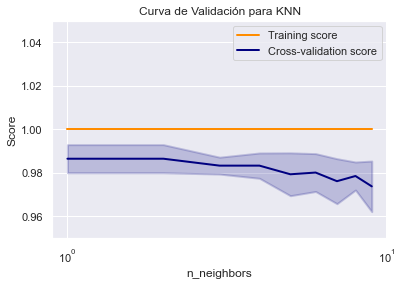

In [30]:
#Curva de validación (copiado del link del enunciado)

from sklearn.model_selection import validation_curve

param_range = np.array([i for i in range(1,10)])

# Validation curve 
# Se utilizan los mejores hiperparámetros encontrado en el ejercicio 3 menos n_neighbors
# pues este se varía en la curva de validación
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(algorithm = 'auto', metric = 'euclidean', weights = 'distance'), #
    X_train,
    y_train,
    param_name="n_neighbors",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=1
)
parameters = {'kernel':['rbf'], 'C': np.arange(1,10)}
svm = SVC()
gs = GridSearchCV(svm, parameters,return_train_score=True)
gs.fit(X_train,y_train)
C_values= np.arange(1,10)
test_accuracy = []
for C_val in C_values:
    svm = SVC(kernel='rbf', C=C_val)
    svm.fit(X_train,y_train)
    test_accuracy.append(svm.score(X_test,y_test))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Curva de Validación para KNN")
plt.xlabel("n_neighbors")
plt.ylabel("Score")

plt.ylim(0.95, 1.05)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

plt.show()

Se observa que la línea de training score es perfecta e igual a 1 pues el modelo KNN guarda en la memoria todo el train set y luego lo ocupa para predecir. Por lo tanto, al predecir con el train set, ya tiene exactamente su cluster apropiado.



# Curva ROC

In [31]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y = label_binarize(y, classes=digits["target"].unique())
n_classes = y.shape[1]

n_samples, n_features = X.shape

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    train_size = 0.7,
                                                    random_state=1998)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(KNeighborsClassifier(algorithm = 'auto', metric = 'euclidean', weights = 'distance'))
y_score = classifier.fit(X_train, y_train).predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


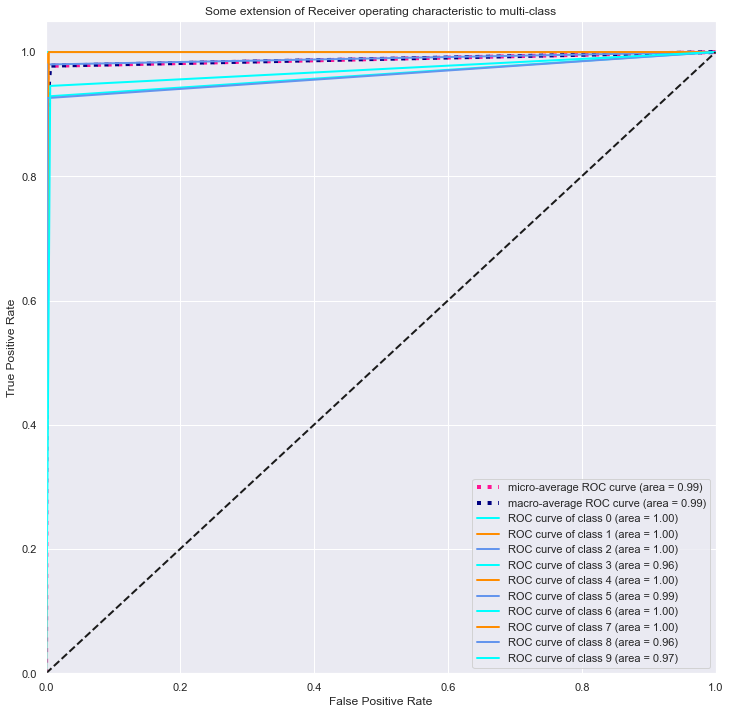

In [32]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,12))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Se observa que la curva es cercana a perfecta para casi todas las clases debido a lo explicado en el gráfico anterior. Habiendo dicho esto, las curvas con una leve inclinación, se deben a que el modelo aun si fue bastante bueno en las métricas, no las tuvo perfectas.

### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


# **Selección de atributos**

In [33]:
#Notar que las columnas que se presentan tienen un solo valor constante igual a 0
print(digits["c00"].unique())
print(digits["c32"].unique())
print(digits["c39"].unique())

[0]
[0]
[0]


In [34]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Separamos las columnas objetivo
x_training = digits.drop(['c00','c32','c39','target'], axis=1) #Se dropean las columnas constantes mencionadas anteriormente
y_training = digits['target']

# Aplicando el algoritmo univariante de prueba F.
k = 20  # número de atributos a seleccionar
columnas = list(x_training.columns.values)
seleccionadas = SelectKBest(f_classif, k=k).fit(x_training, y_training)

In [35]:
catrib = seleccionadas.get_support()
atributos = [columnas[i] for i in list(catrib.nonzero()[0])]
digits_atributos = digits[atributos + ["target"]]
print("Las columnas seleccionadas por la prueba F son:\n",atributos)

Las columnas seleccionadas por la prueba F son:
 ['c02', 'c10', 'c13', 'c20', 'c21', 'c26', 'c28', 'c30', 'c33', 'c34', 'c36', 'c38', 'c42', 'c43', 'c44', 'c46', 'c54', 'c58', 'c60', 'c61']


In [36]:
dfs_size = [digits.size,digits_atributos.size]
print("digits Original tenía", dfs_size[0], "elementos")
print("digits_atributos tiene", dfs_size[1], "elementos")

digits Original tenía 116805 elementos
digits_atributos tiene 37737 elementos


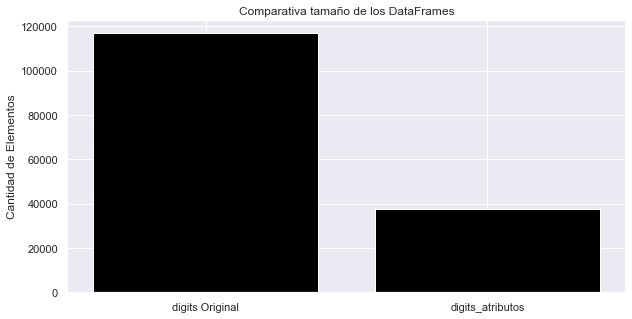

In [37]:
fig = plt.figure(figsize=(10,5))
plt.bar(x =["digits Original", "digits_atributos"], height = dfs_size, color = "BLACK" )
plt.title("Comparativa tamaño de los DataFrames")
plt.ylabel("Cantidad de Elementos")
plt.show()

In [38]:
#Se suma la memoria de cada columna para conocer el total
total2 = 0
memoria = digits_atributos.memory_usage() #Se determina la memoria usada en el DataFrame nuevo por columna
for i in range(0,len(memoria)):
    total2 += memoria[i]
print("El DataFrame digits_atributos usa un total de:",total2, 'bytes') 
print('En comparación el DataFrame original usaba un total de:', total, 'bytes')

El DataFrame digits_atributos usa un total de: 151076 bytes
En comparación el DataFrame original usaba un total de: 467348 bytes


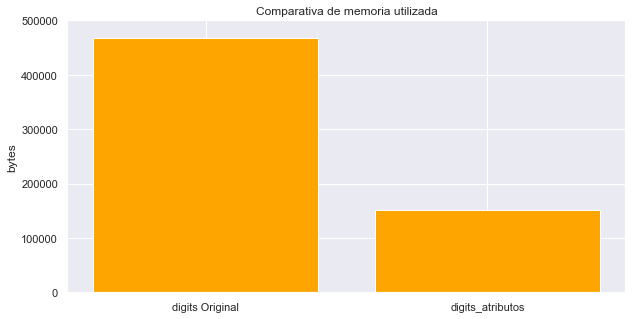

In [39]:
lista = [1e5 * i for i in range(6)]
fig = plt.figure(figsize=(10,5))
plt.bar(x = ["digits Original", "digits_atributos"], height = [total,total2],color = "orange")
plt.yticks(lista)
plt.title("Comparativa de memoria utilizada")
plt.ylabel("bytes")
plt.show()

In [40]:
X = digits.drop("target",axis = 1)
y = digits["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    train_size=0.70,
                                                    random_state=1998)
start_time = time.time()
clfsvm.fit(X_train, y_train)
# Se presenta el tiempo en que se ejecutó el modelo con el dataset original
time_original = time.time() - start_time
print(" El modelo se ejecutó en %s segundos con el DataFrame Original" % (time_original)) 

 El modelo se ejecutó en 0.036125898361206055 segundos con el DataFrame Original


In [41]:
#Spliteo train-test con el dataframe digits_pca
X = digits_atributos.drop("target",axis=1)
y = digits["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    train_size=0.70,
                                                    random_state=1998)
start_time = time.time()
clfsvm.fit(X_train, y_train)
# Se presenta el tiempo en que se ejecutó el modelo con el dataframe digits_pca
time_atributos = time.time() - start_time
print(" El modelo se ejecutó en %s segundos con el DataFrame digits_atributos" % (time_atributos)) 

 El modelo se ejecutó en 0.03211355209350586 segundos con el DataFrame digits_atributos


# PCA

In [42]:
from sklearn.preprocessing import StandardScaler

#Se estandarizan los datos pues pca es suceptible a la distribucion de los datos
x = digits.drop("target",axis =1).values
y = digits["target"].values

x = StandardScaler().fit_transform(x)

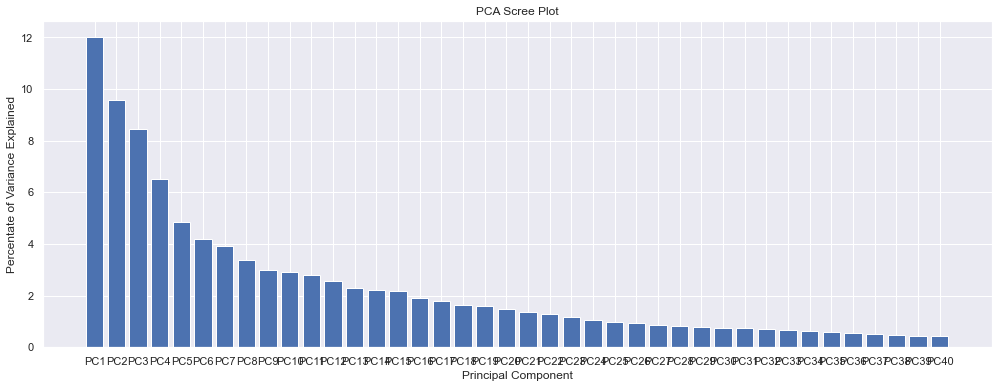

In [43]:
# Se ajusta el modelo 
from sklearn.decomposition import PCA
n_components = 40
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(x)

# graficar varianza por componente
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = [f"PC{i}" for i in range(1,n_components+1)]

plt.figure(figsize=(17,6))
plt.bar(x= range(1,n_components+1), height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

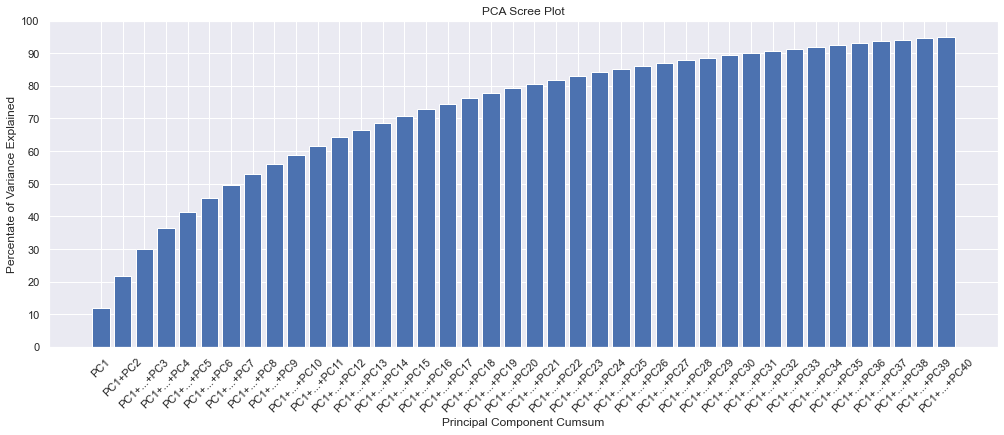

In [44]:
# graficar varianza por la suma acumulada de los componente
percent_variance_cum = np.cumsum(percent_variance)
columns_sum =[f"PC1+...+PC{i+1}" for i in range(2,n_components)]
columns_sum = ["PC1", "PC1+PC2"] + columns_sum

plt.figure(figsize=(17,6))
plt.bar(x= range(1,n_components+1), height=percent_variance_cum, tick_label=columns_sum)
plt.ylabel('Percentate of Variance Explained')
plt.yticks([10*i for i in range(11)])
plt.xlabel('Principal Component Cumsum')
plt.xticks(rotation =45)
plt.title('PCA Scree Plot')
plt.show()

In [45]:
principalDataframe = pd.DataFrame(data = principalComponents, columns = columns)
targetDataframe = digits[['target']]

digits_pca = pd.concat([principalDataframe, targetDataframe],axis = 1)
digits_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,target
0,1.914214,-0.954501,-3.946035,2.028723,-0.267169,0.530326,-1.415322,1.496049,0.124917,-0.822239,...,-0.013378,0.044388,0.025932,0.123738,0.699111,0.075828,0.819611,0.005358,0.324402,0
1,0.588980,0.924636,3.924755,-1.779851,-0.993430,-0.675651,1.878566,0.556339,1.079876,0.087450,...,-1.144341,0.036548,0.369465,-0.671705,-0.003701,-0.246234,0.200449,0.085188,-0.496125,1
2,1.302039,-0.317189,3.023333,-2.043377,-2.081158,0.935121,-1.296198,1.156172,0.785592,-1.099210,...,0.483504,-1.352827,-0.111434,0.139389,-0.066700,0.423335,-0.239576,-1.242360,0.552450,2
3,-3.020770,-0.868772,-0.801744,-2.187039,-0.556814,0.727125,0.959768,-1.382633,0.259071,0.744553,...,0.877279,0.117764,-0.472934,-0.154729,0.241586,0.402531,0.185345,0.813108,-0.046793,3
4,4.528949,-1.093480,0.973121,-1.419509,-1.715103,1.431591,1.073647,-0.968252,-1.660209,1.174599,...,-0.358389,0.267456,0.504850,-0.252236,-0.594959,-0.190235,-0.207091,-0.180729,0.190065,4


In [46]:
dfs_pca_size = [digits.size,digits_pca.size]
print("digits Original tenía", dfs_pca_size[0], "elementos")
print("digits_atributos tiene", dfs_pca_size[1], "elementos")

digits Original tenía 116805 elementos
digits_atributos tiene 73677 elementos


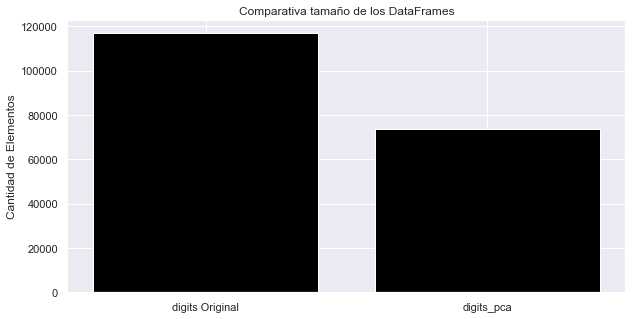

In [47]:
fig = plt.figure(figsize=(10,5))
plt.bar(x =["digits Original", "digits_pca"], height = dfs_pca_size, color = 'black' )
plt.title("Comparativa tamaño de los DataFrames")
plt.ylabel("Cantidad de Elementos")
plt.show()

In [48]:
#Se suma la memoria de cada columna para conocer el total
total3 = 0
memoria = digits_pca.memory_usage() #Se determina la memoria usada en el DataFrame nuevo por columna
for i in range(0,len(memoria)):
    total3 += memoria[i]
print("El DataFrame digits_pca usa un total de:",total2, 'bytes') 
print('En comparación el DataFrame original usaba un total de:', total, 'bytes')

El DataFrame digits_pca usa un total de: 151076 bytes
En comparación el DataFrame original usaba un total de: 467348 bytes


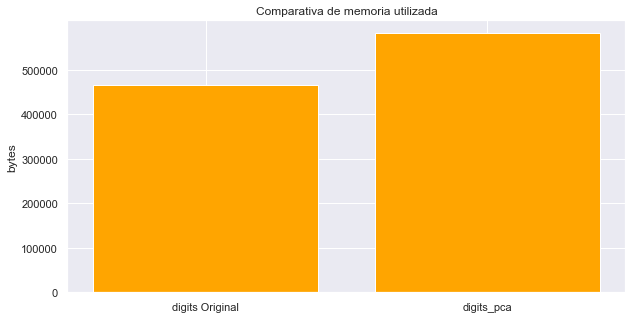

In [49]:
lista = [1e5 * i for i in range(6)]
fig = plt.figure(figsize=(10,5))
plt.bar(x = ["digits Original", "digits_pca"], height = [total,total3],color = "orange")
plt.yticks(lista)
plt.title("Comparativa de memoria utilizada")
plt.ylabel("bytes")
plt.show()

In [50]:
X = digits.drop("target",axis = 1)
y = digits["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    train_size=0.70,
                                                    random_state=1998)
start_time = time.time()
clfsvm.fit(X_train, y_train)
# Se presenta el tiempo en que se ejecutó el modelo con el dataset original
time_original = time.time() - start_time
print(" El modelo se ejecutó en %s segundos con el DataFrame Original" % (time_original)) 

 El modelo se ejecutó en 0.03611612319946289 segundos con el DataFrame Original


In [51]:
#Spliteo train-test con el dataframe solo con atributos
X = digits_pca.drop("target",axis=1)
y = digits["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    train_size=0.70,
                                                    random_state=1998)
start_time = time.time()
clfsvm.fit(X_train, y_train)
# Se presenta el tiempo en que se ejecutó el modelo con el dataset solo con atributos
time_pca = time.time() - start_time
print(" El modelo se ejecutó en %s segundos con el DataFrame digits_pca" % (time_pca)) 

 El modelo se ejecutó en 0.04469728469848633 segundos con el DataFrame digits_pca


### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [52]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    
    
    X = digits.drop(columns="target").values
    Y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    Y_pred = list(model.predict(X_test))

    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = Y_pred == Y_test
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = Y_pred != Y_test
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    X_aux = X_test[mask]
    y_aux_true = np.array(Y_test)[mask]
    y_aux_pred = np.array(Y_pred)[mask]

    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            data  = X_aux[index, :].reshape(8,8)
            label_pred = str(int(y_aux_pred[index]))
            label_true = str(int(y_aux_true[index]))
            ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
            ax[i][j].text(0, 0, label_pred, horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
            ax[i][j].text(7, 0, label_true, horizontalalignment='center', verticalalignment='center', fontsize=10, color='blue')
            ax[i][j].get_xaxis().set_visible(False)
            ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

In [53]:
modelo = SVC(kernel= 'rbf', C=4) # Mejor modelo

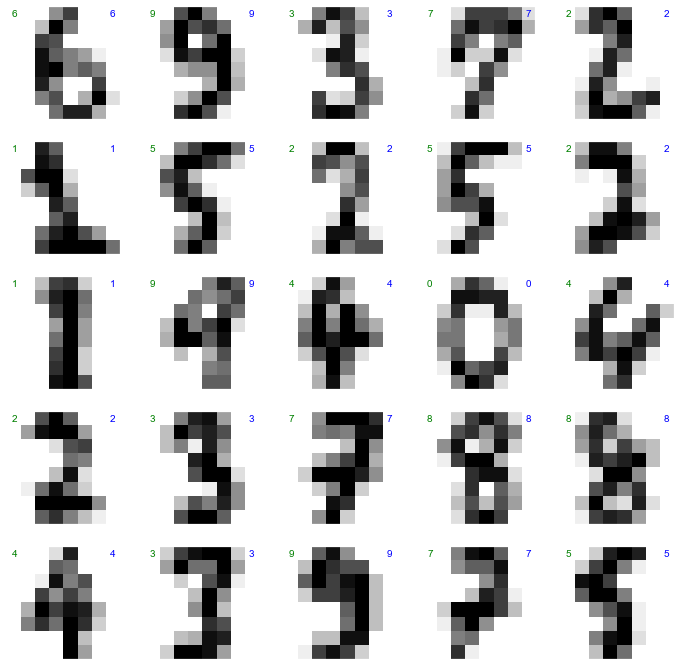

In [54]:
mostar_resultados(digits,modelo,nx=5, ny=5,label = "correctos")

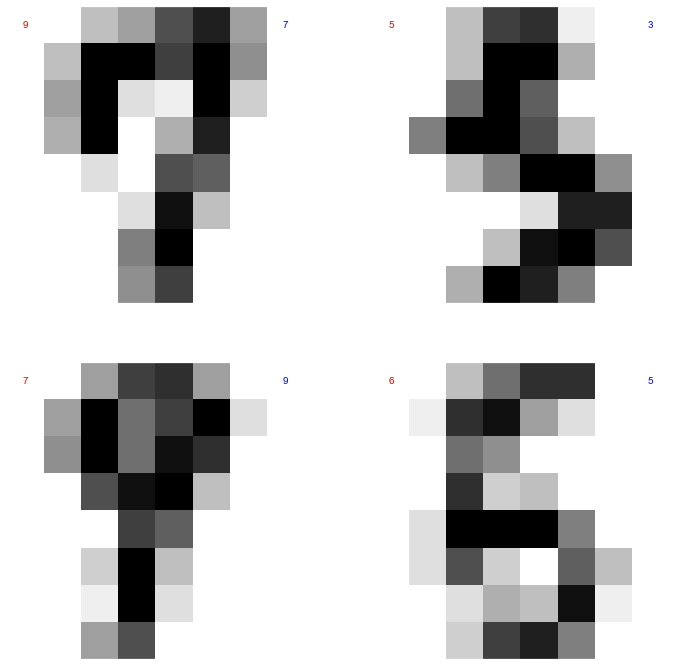

In [55]:
mostar_resultados(digits,modelo,nx=2, ny=2,label = "incorrectos")

¿Por qué ocurren estas fallas?

ya que visualmente los valores supuestamente verdaderos, generan mucha confusión con otros números, por ejemplo, el que tiene como valor real 5, visualmente parece un 6. Llevando esto a SVM, deben ser puntos muy cercanos a la frontera de decisión de SVM, los cuales son puntos que el hiperplano no tiene tanta seguridad al clasificar.

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.

El modelo en general funciona muy bien, reflejandose en su accuracy, muy cercano a $1$. Las visualizaciones denotan variables en su mayoría muy explicativas lo que hace un problema muy facil de resolver, y las dificultades radican principalmente en tratar de identificar eliminar variables que generan confusión al modelo a la hora de clasificar

## II.- California Housing Prices


<img src="https://www.wartsila.com/images/default-source/default-album/california_housing.tmb-1920x690.jpg?sfvrsn=126bc44_1" width="480" height="240" align="center"/>

Los datos se refieren a las casas encontradas en un distrito determinado de California y algunas estadísticas resumidas sobre ellas basadas en los datos del censo de 1990. Tenga en cuenta que los datos no se limpian, por lo que se requieren algunos pasos de procesamiento previo.

Las columnas son las siguientes, sus nombres se explican por sí mismos:

* longitude
* latitude
* housingmedianage
* total_rooms
* total_bedrooms
* population
* households
* median_income
* medianhousevalue
* ocean_proximity


El objetivo es poder predecir el valor promedio de cada propiedad. 
Para poder completar correctamente este laboratorio, es necesario seguir la siguiente rúbrica de trabajo:

1. Definición del problema
2. Estadística descriptiva
3. Visualización descriptiva
4. Preprocesamiento
5. Selección de modelo 
    1. Por lo menos debe comparar cuatro modelos
    2. Al menos tres de estos modelos tienen que tener hiperparámetros.
    3. Realizar optimización de hiperparámetros.
6. Métricas y análisis de resultados
7. Visualizaciones del modelo
8. Conclusiones

> **Observación**: Puede tomar como referencia lo realizado en la sección **I.- Clasificación de dígitos**. El alumno tiene la libertad de desarrollar un análisis más completo del problema (si así lo desea). Puede tomar como referencia el siguiente [link](https://www.kaggle.com/camnugent/california-housing-prices).

In [56]:
import matplotlib
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
sns.set(style="white")
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definición del problema

durante 1990, en california se realizo un censo, donde reunio informacion sobre las casas de la ciudad, tal informacio consiste en la longitud, latitud, total de cuartos, total de baños, la poblacion, los hogares, el ingraso medio y la proximidad al oceano. El problema consiste en dada la informacion mencionada, estimar el valor de la casa dado el valor de algunas de estas.
Tales valores se pueden ver resumidos en el siguiente dataframe:

In [57]:
# read data
housing = pd.read_csv('data/housing.csv',sep=',')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Estadistica descriptiva

In [58]:
housing.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


#  Visualización descriptiva

In [59]:
def correlation_heatmap(data_frame=housing):
    """arguments: data_frame:pandas DataFrame
       returns: correlation heatmap"""
    
    #  setting the context
    sns.set(context='paper', font='moonspace')
    
    #  making correlation object and saving it into variable
    correlation = housing.corr()
    
    #  creating heatmap figure object (paper) and ax object (the plot)
    fig, ax = plt.subplots(figsize=(12, 8))
    
    #  generating color palettes
    cmap = sns.diverging_palette(220, 10, center='light', as_cmap=True)
    
    #  draw the heatmap
    heatmap = sns.heatmap(correlation, vmax=1,vmin=-1,center=0, square=False, annot=True, cmap=cmap,
                         lw=2, cbar=False)
    
    return heatmap

findfont: Font family ['moonspace'] not found. Falling back to DejaVu Sans.


<AxesSubplot:>

findfont: Font family ['moonspace'] not found. Falling back to DejaVu Sans.


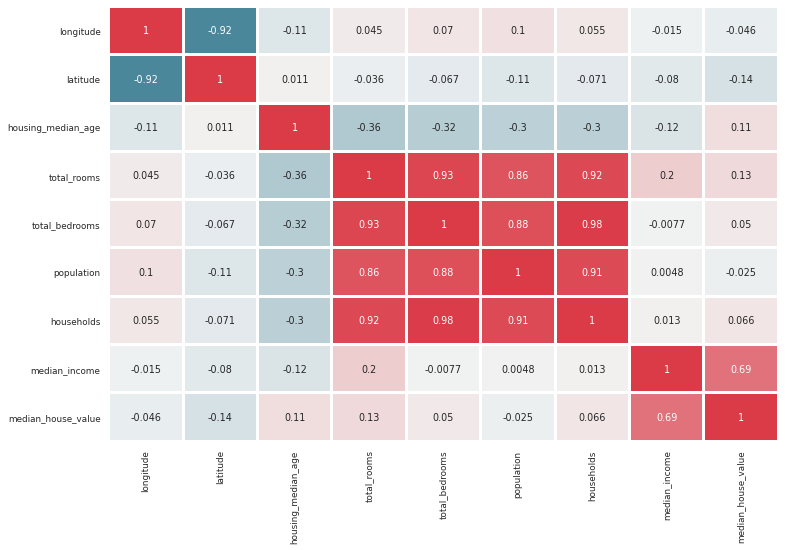

In [60]:
correlation_heatmap(housing)

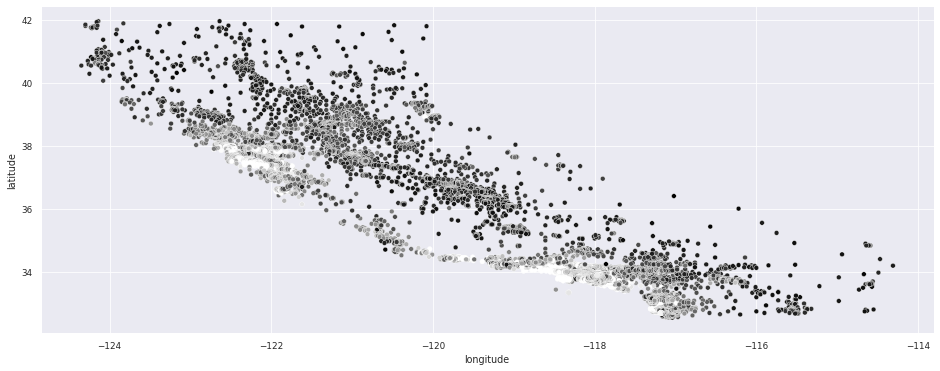

In [64]:
plt.figure(figsize=(16,6))
fig = sns.scatterplot(housing.longitude, housing.latitude, hue=housing['median_house_value'],
                      legend=False, palette='gray');

In [65]:
housing.isnull().sum() #  valores nulos

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

como hay 207 nulos en 'total_bedrooms' se manipularan los datos bajo el enfoque de aprendizaje no supervisado, donde se escogio KNN.

# Preprocesamiento

Tal preprocesamiento fue obtenido de un usuario de kaggle

In [66]:
# reemplazamos valores faltantes.
housing.total_bedrooms.fillna(method='pad', inplace=True)
housing.isnull().sum() #  valores nulos

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

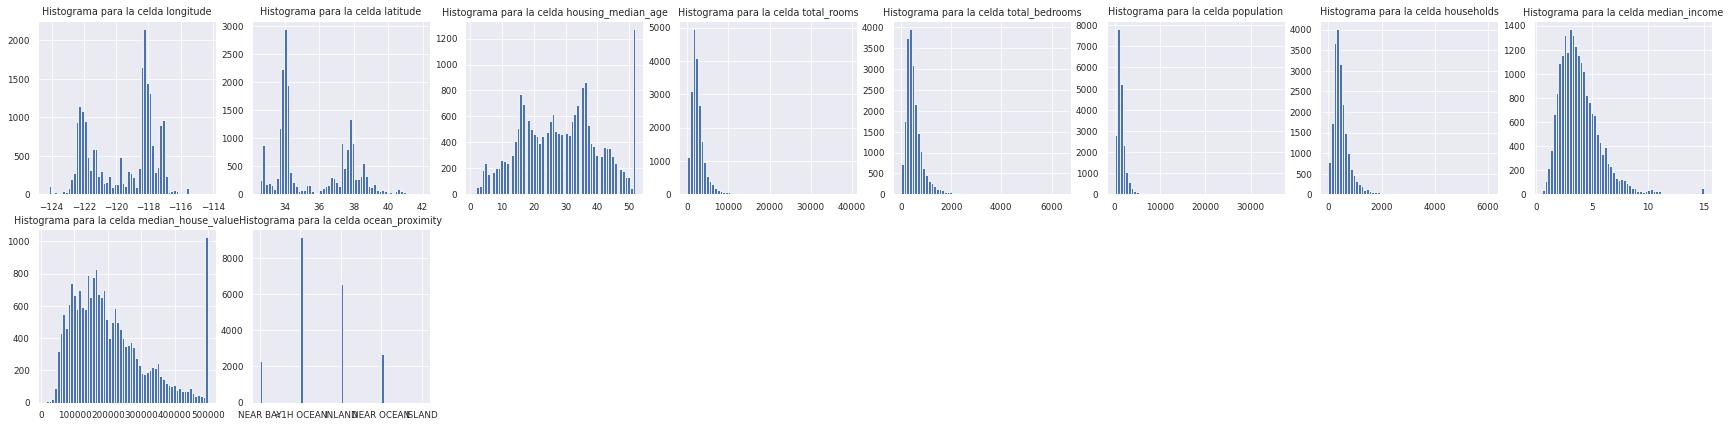

In [67]:
figure(num=None, figsize=(30, 30)) #Ajustamos nuestra ventana de ploteo
k=1 #Establesemos un contador para el ploteo.
for i in housing.columns: #recorrer columnas para generar histogramas
    plt.subplot(8,8,k)
    plt.hist(housing[i], bins = 60)
    plt.title('Histograma para la celda '+i)
    k+=1

plt.show()

In [68]:
#quitando outliars de la columna 'population'
housing.sort_values(by='population', ascending=False)
housing = housing.drop(labels = [15360, 9880])

# Selección del modelo

# Regresión lineal

In [69]:
X = housing.drop(['median_house_value', 'ocean_proximity'], axis=1)
y = housing['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,
                                                   random_state=42)
reg = LinearRegression()

reg.fit(X_train, y_train) # entrenamiento

LinearRegression()

In [70]:
predictions=reg.predict(X_test) #predicciones

In [71]:
LR1=mean_absolute_error(y_test, predictions)
LR2=mean_squared_error(y_test, predictions)
LR3=r2_score(y_test, predictions)
lineal_regression = ('regresion lineal', LR1, LR2, LR3)

In [72]:
print('MAE: ' + str(mean_absolute_error(y_test, predictions)))
print('MSE: ' + str(mean_squared_error(y_test, predictions)))
print('Score: '+ str(r2_score(y_test, predictions)))

MAE: 51093.65931142629
MSE: 4876674285.252958
Score: 0.6391209210421758


# KNN

In [73]:
X = housing.drop(['median_house_value', 'ocean_proximity'], axis=1)
y = housing['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,
                                                   random_state=22)

In [74]:
parameters = {'n_neighbors':[1, 10]}
knn = KNeighborsClassifier()
gs = GridSearchCV(knn, parameters)
gs.fit(X_train, y_train)
print("Best: %f con %s" % (gs.best_score_, gs.best_params_))

Best: 0.029282 con {'n_neighbors': 10}


In [75]:
params = {
    'n_neighbors': [10],  
    }

knn = KNeighborsRegressor()
rs = GridSearchCV(estimator=knn, param_grid=params)
rs.fit(X_train, y_train)
print(rs.best_estimator_)
knn = rs.best_estimator_
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

KNeighborsRegressor(n_neighbors=10)


In [76]:
KN1=mean_absolute_error(y_test, pred)
KN2=mean_squared_error(y_test, pred)
KN3=r2_score(y_test, pred)
K_N_N = ('KNN', KN1, KN2, KN3)

In [77]:
print('MAE : ' + str(mean_absolute_error(y_test, pred)))
print('MSE : ' + str(mean_squared_error(y_test, pred)))
print('Score : '+ str(r2_score(y_test, pred)))

MAE : 73617.5401001292
MSE : 8958767200.235111
Score : 0.30969360579723915


# Decision Tree

In [78]:
from sklearn.tree import DecisionTreeRegressor
X = housing.drop(['median_house_value', 'ocean_proximity'], axis=1)
y = housing['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,
                                                   random_state=22)

In [79]:
params = {'max_depth': [7], 
          'max_features': ['auto', 'sqrt'], 
          'min_samples_leaf': [7], 
          'min_samples_split': [0.1],
          'criterion': ['mse'] 
         }

tree = DecisionTreeRegressor()
rs = GridSearchCV(estimator=tree, param_grid=params)
rs.fit(X_train, y_train)
tree = rs.best_estimator_
tree.fit(X_train, y_train)
pred = tree.predict(X_test)

In [80]:
DT1=mean_absolute_error(y_test, pred)
DT2=mean_squared_error(y_test, pred)
DT3=r2_score(y_test, pred)
decision_tree = ('Decision Tree', DT1, DT2, DT3)

In [81]:
print('MAE: ' + str(mean_absolute_error(y_test, pred)))
print('MSE: ' + str(mean_squared_error(y_test, pred)))
print('Score: '+ str(r2_score(y_test, pred)))

MAE: 56703.42901862068
MSE: 5761772320.299551
Score: 0.5560339736767714


# Random Forest

In [82]:
X = housing.drop(['median_house_value', 'ocean_proximity'], axis=1)
y = housing['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,
                                                   random_state=22)

param_grid = [
    {'n_estimators': [3, 10, 30, 60], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [8, 10, 12]}
]
rf_reg = RandomForestRegressor()
gs = GridSearchCV(rf_reg, param_grid)
gs.fit(X_train, y_train)
print("Best: %f con %s" % (gs.best_score_, gs.best_params_))

Best: 0.807425 con {'max_features': 6, 'n_estimators': 60}


In [83]:
param_grid = [
    {'n_estimators': [60], 'max_features': [6]}
]

In [84]:
grid_searchRF = GridSearchCV(rf_reg, param_grid)
grid_searchRF.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [6], 'n_estimators': [60]}])

In [85]:
predic=grid_searchRF.predict(X_test)

In [86]:
RF1=mean_absolute_error(y_test, predic)
RF2=mean_squared_error(y_test, predic)
RF3=r2_score(y_test, predic)

In [87]:
print('MAE : ' + str(mean_absolute_error(y_test, predic)))
print('MSE : ' + str(mean_squared_error(y_test, predic)))
print('Score : '+ str(r2_score(y_test, predic)))
random_forest = ('Random Forest', RF1, RF2, RF3)

MAE : 31923.521258613262
MSE : 2293109452.391984
Score : 0.8233073722965549


In [88]:
df_results = pd.DataFrame([lineal_regression, K_N_N, decision_tree, random_forest], columns=['model', 'MAE','MSE','R2'])
df_results.sort_values('R2',ascending=False)

,model,MAE,MSE,R2
3,Random Forest,31923.521259,2.293109e+09,0.823307
0,regresion lineal,51093.659311,4.876674e+09,0.639121
2,Decision Tree,56703.429019,5.761772e+09,0.556034
1,KNN,73617.540100,8.958767e+09,0.309694


Dados los resultados el modelo que mejor predice es el random forest

# Visualizaciones del modelo

In [92]:
# Ejemplo con cross_val_score
from sklearn.model_selection import cross_val_score

precision = cross_val_score(estimator=grid_searchRF,
                            X=X_train,
                            y=y_train,
                            cv=10)

In [90]:
precision = [round(x,2) for x in precision]
print('Precisiones: {} '.format(precision))
print('Precision promedio: {0: .3f} +/- {1: .3f}'.format(np.mean(precision),
                                          np.std(precision)))

Precisiones: [0.8, 0.81, 0.8, 0.81, 0.82, 0.81, 0.81, 0.83, 0.8, 0.81] 
Precision promedio:  0.810 +/-  0.009


In [94]:
# Ejemplo Curvas de aprendizaje
from sklearn.model_selection import  learning_curve

train_sizes, train_scores, test_scores = learning_curve(
                        estimator=grid_searchRF,
                        X=X_train,
                        y=y_train, 
                        train_sizes=np.linspace(0.1, 1.0, 20),
                        cv=5,
                        n_jobs=-1
                        )

# calculo de metricas
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

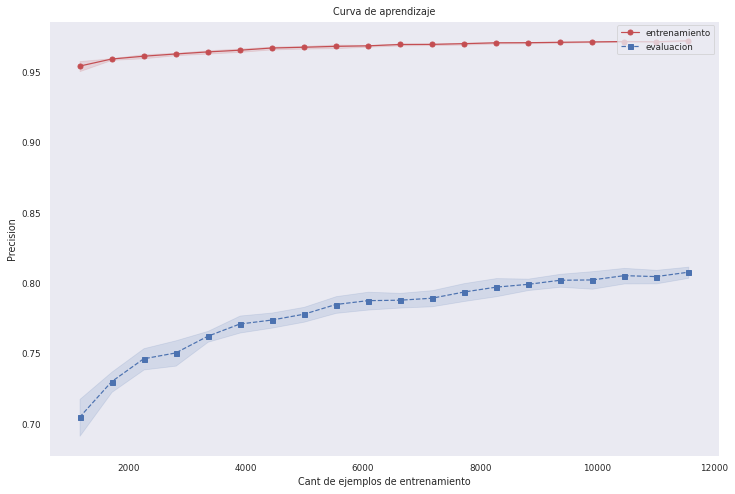

In [96]:
# graficando las curvas
plt.figure(figsize=(12,8))

plt.plot(train_sizes, train_mean, color='r', marker='o', markersize=5,
         label='entrenamiento')
plt.fill_between(train_sizes, train_mean + train_std, 
                 train_mean - train_std, alpha=0.15, color='r')
plt.plot(train_sizes, test_mean, color='b', linestyle='--', 
         marker='s', markersize=5, label='evaluacion')
plt.fill_between(train_sizes, test_mean + test_std, 
                 test_mean - test_std, alpha=0.15, color='b')
plt.grid()
plt.title('Curva de aprendizaje')
plt.legend(loc='upper right')
plt.xlabel('Cant de ejemplos de entrenamiento')
plt.ylabel('Precision')
plt.show()

# Conclusiones 

Finalmente, podemos ver que el mejor escenario es cuando ocupamos Random Forest, esto deducido del cross validation y las metricas de comparacion con los otros modelos, el cual fue el criterio utilizado para discriminar entre todas las alternativas. 
Para este caso en concreto, no fue necesario de una reduccion de dimensionalidad, debido a que solo hay 8 atributos.